# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [15]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import math
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
from comtypes import CLSCTX_ALL
from ctypes import cast, POINTER

In [16]:
devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(IAudioEndpointVolume._iid_, CLSCTX_ALL, None)
volume = cast(interface, POINTER(IAudioEndpointVolume))
    
def volumeUp(val = .1):
    global volume
    current_volume = volume.GetMasterVolumeLevelScalar()
    newVol = min(1.0, current_volume + val)
    volume.SetMasterVolumeLevelScalar(newVol, None)
    print(newVol)
    
def volumeDown(val = .1):
    global volume
    current_volume = volume.GetMasterVolumeLevelScalar()
    newVol = max(0.0, current_volume - val)
    volume.SetMasterVolumeLevelScalar(newVol, None)
    print(newVol)

# 2. Keypoints using MP Holistic

In [17]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [18]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [19]:
def draw_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    #mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    #mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [20]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [21]:
def recognize_hand_direction(results):
    if results.right_hand_landmarks is None:
        return None, None
    
    start_finger = results.right_hand_landmarks.landmark[5]
    end_finger = results.right_hand_landmarks.landmark[8]
    
    
    if end_finger.x > start_finger.x:
        horizontaly = 'left'
    else:
        horizontaly = 'right'
    
    if end_finger.y < start_finger.y:
        vertically = 'top'
    else:
        vertically = 'bottom'
        
    return horizontaly, vertically
    

In [22]:
def get_target_points(results):
    if results.right_hand_landmarks is None:
        return None, None
    
    start_finger = results.right_hand_landmarks.landmark[5]
    end_finger = results.right_hand_landmarks.landmark[8]
    
    return start_finger, end_finger

In [23]:
def line_distance(x1, y1, x2, y2):
    return math.sqrt(((x2 - x1)**2) + ((y2 - y1)**2))

In [24]:
line_distance(1, 1, 2, 2)

1.4142135623730951

In [25]:
def get_cos(results):
    if results.right_hand_landmarks is None:
        return None, None, None
    start_finger, end_finger = get_target_points(results)
    mojaver = (end_finger.y - start_finger.y) * (-1) * 100
   # if mojaver < 0:
   #     mojaver *= -1
    vatar = line_distance(end_finger.x, end_finger.y, start_finger.x, start_finger.y) * 100
    cos = (mojaver / vatar) * 100
    
    horizontaly, vertically = recognize_hand_direction(results)
    if horizontaly == 'right' and vertically == 'top':
        cos = 90 + (90 - cos)
    
    return mojaver, vatar, cos

In [37]:
class Rotating:
    def __init__(self):
        self.increase_count = 0
        self.decrease_count = 0
        
    def increase(self):
        self.increase_count += 1
        self.decrease_count = 0
        self.check()
        
    def decrease(self):
        self.decrease_count += 1
        self.increase_count = 0
        self.check()
        
    def check(self):
        if self.increase_count >= 7:
            volumeUp()
            print('increase')
            self.increase_count = 0
        elif self.decrease_count >= 7:
            volumeDown()
            print('decrease')
            self.decrease_count = 0

In [32]:
prev_cos = None

def checkRotate(rotating, results):
    global prev_cos
    horizontaly, vertically = recognize_hand_direction(results)
    mojaver, vatar, cos = get_cos(results)

    if prev_cos is None:
        prev_cos = cos

    if cos is not None:
        if cos >= 0:
            if cos > prev_cos:
                rotating.increase()
            elif cos < prev_cos:
                rotating.decrease()
        else:
            if horizontaly == 'right':
                if cos > prev_cos:
                    rotating.decrease()
                elif cos < prev_cos:
                    rotating.increase()
            else:
                if cos > prev_cos:
                    rotating.increase()
                elif cos < prev_cos:
                    rotating.decrease()
                    
    prev_cos = cos

In [38]:
cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
rotating = Rotating()
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv2.rotate(frame, cv2.ROTATE_180)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        checkRotate(rotating, results)
        

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

0.1999998927116394
decrease
0.29999989867210386
increase
0.1999998927116394
decrease
0.29999989867210386
increase
0.1999998927116394
decrease
0.29999989867210386
increase
0.3999998927116394
increase
0.29999988675117495
decrease
0.3999998927116394
increase
0.4999998867511749
increase
0.5999999105930328
increase
0.6999999046325683
increase
0.7999999284744262
increase
0.8999999523162842
increase
0.9999999761581421
increase
0.9
decrease
0.7999999761581421
decrease
0.6999999523162842
decrease
0.5999999284744263
decrease
0.4999999046325684
decrease
0.39999991059303286
decrease
0.29999991655349734
decrease
0.1999998927116394
decrease
0.09999989867210388
decrease
0.0
decrease
0.1
increase
0.20000000894069672
increase
0.3000000178813934
increase
0.40000001192092893
increase
0.5000000059604645
increase
0.6
increase
0.7000000238418579
increase
0.8000000476837158
increase
0.9000000715255737
increase
1.0
increase
1.0
increase
0.9
decrease
0.7999999761581421
decrease
0.6999999523162842
decrease
0.79

In [16]:
sessions = AudioUtilities.GetAllSessions()

for session in sessions:
    volume = session._ctl.QueryInterface(ISimpleAudioVolume)
    if session.Process:
        print(session.Process.name())
    print("volume.GetMasterVolume(): %s" % volume.GetMasterVolume())

Discord.exe
volume.GetMasterVolume(): 1.0
volume.GetMasterVolume(): 1.0
PotPlayerMini64.exe
volume.GetMasterVolume(): 1.0


In [14]:
draw_landmarks(frame, results)

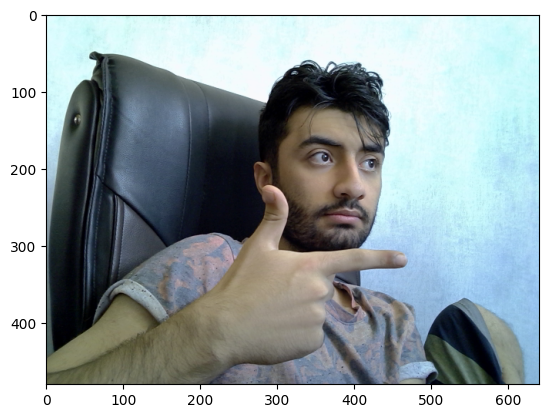

In [43]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [44]:
frame

array([[[254, 253, 224],
        [254, 253, 224],
        [255, 254, 221],
        ...,
        [255, 252, 219],
        [255, 252, 219],
        [254, 250, 217]],

       [[254, 253, 224],
        [254, 253, 224],
        [255, 254, 221],
        ...,
        [254, 252, 219],
        [255, 252, 219],
        [254, 250, 217]],

       [[255, 253, 226],
        [255, 253, 226],
        [255, 254, 223],
        ...,
        [255, 253, 220],
        [255, 252, 219],
        [254, 250, 217]],

       ...,

       [[ 72, 100,  96],
        [ 73, 101,  97],
        [ 71,  99,  95],
        ...,
        [213, 181, 135],
        [215, 182, 140],
        [214, 181, 139]],

       [[ 74, 102,  98],
        [ 70,  98,  94],
        [ 69,  97,  93],
        ...,
        [210, 177, 133],
        [214, 181, 139],
        [210, 177, 135]],

       [[ 75, 101,  98],
        [ 73,  99,  96],
        [ 73, 101,  97],
        ...,
        [208, 175, 131],
        [206, 177, 137],
        [205, 176, 136]]

# 3. Extract Keypoint Values

In [47]:
results.right_hand_landmarks

landmark {
  x: 0.37266666
  y: 0.84899336
  z: 1.3559296e-08
}
landmark {
  x: 0.3821242
  y: 0.72594124
  z: 0.0076536215
}
landmark {
  x: 0.43167973
  y: 0.63370216
  z: -0.001709203
}
landmark {
  x: 0.46584415
  y: 0.548429
  z: -0.012838679
}
landmark {
  x: 0.45820197
  y: 0.48174724
  z: -0.026943717
}
landmark {
  x: 0.52616173
  y: 0.6773957
  z: -0.02165727
}
landmark {
  x: 0.62470764
  y: 0.666241
  z: -0.025506373
}
landmark {
  x: 0.68163085
  y: 0.6660064
  z: -0.027208677
}
landmark {
  x: 0.724535
  y: 0.6701727
  z: -0.028816456
}
landmark {
  x: 0.5526138
  y: 0.7455039
  z: -0.023957944
}
landmark {
  x: 0.57386696
  y: 0.75458276
  z: -0.013625824
}
landmark {
  x: 0.540615
  y: 0.7605916
  z: 0.0035022243
}
landmark {
  x: 0.50927395
  y: 0.766541
  z: 0.012313624
}
landmark {
  x: 0.55389917
  y: 0.8160409
  z: -0.023504443
}
landmark {
  x: 0.5527638
  y: 0.8113647
  z: -0.0104985135
}
landmark {
  x: 0.5250906
  y: 0.81768936
  z: 0.0024196117
}
landmark {
  

In [141]:
print(results.right_hand_landmarks.landmark[5])

results.right_hand_landmarks.landmark[5].y = .84

AttributeError: 'NoneType' object has no attribute 'landmark'

In [140]:
get_target_points(results)

(None, None)

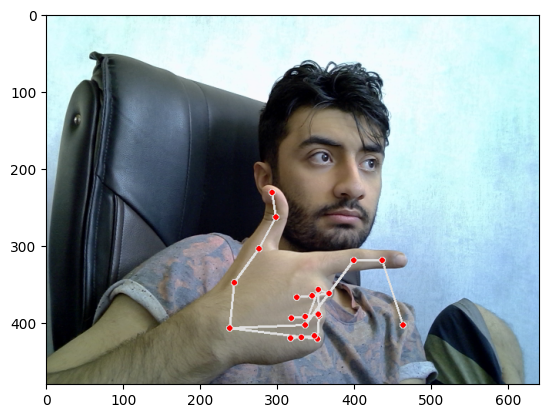

In [59]:
newFrame = frame.copy()

draw_landmarks(newFrame, results)
plt.imshow(cv2.cvtColor(newFrame, cv2.COLOR_BGR2RGB))

In [62]:
recognize_hand_direction(results)

left


In [11]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [12]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [13]:
results.face_landmarks

landmark {
  x: 0.3685129
  y: 0.4120846
  z: -0.03111957
}
landmark {
  x: 0.38061345
  y: 0.35778344
  z: -0.052350007
}
landmark {
  x: 0.36826053
  y: 0.37500283
  z: -0.028875124
}
landmark {
  x: 0.3644309
  y: 0.30952913
  z: -0.042208325
}
landmark {
  x: 0.3819512
  y: 0.34253713
  z: -0.055072837
}
landmark {
  x: 0.3783382
  y: 0.32339302
  z: -0.05026652
}
landmark {
  x: 0.36534888
  y: 0.27736378
  z: -0.022047754
}
landmark {
  x: 0.27327633
  y: 0.2674067
  z: -0.019058198
}
landmark {
  x: 0.36190233
  y: 0.2439576
  z: -0.013692723
}
landmark {
  x: 0.36319295
  y: 0.22475043
  z: -0.014609826
}
landmark {
  x: 0.35907966
  y: 0.15329713
  z: 0.00020294699
}
landmark {
  x: 0.3677976
  y: 0.41970658
  z: -0.029984199
}
landmark {
  x: 0.36582673
  y: 0.4254223
  z: -0.026801253
}
landmark {
  x: 0.36319083
  y: 0.4277775
  z: -0.02253874
}
landmark {
  x: 0.36350524
  y: 0.42866886
  z: -0.021643475
}
landmark {
  x: 0.36442572
  y: 0.43458325
  z: -0.02343435
}
landm

In [14]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() 
    if results.face_landmarks 
    else np.zeros(1404)


IndentationError: unexpected indent (1373052555.py, line 2)

In [12]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [16]:
result_test = extract_keypoints(results)

In [17]:
result_test

array([ 0.37303069,  0.33510193, -1.05016053, ...,  0.        ,
        0.        ,  0.        ])

In [18]:
np.save('0', result_test)

In [19]:
np.load('0.npy')

array([ 0.37303069,  0.33510193, -1.05016053, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [13]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['volumup', 'volumdow'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 50

# Folder start
start_folder = 30

In [16]:
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_path):
        os.makedirs(action_path)

for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    
    # Create the action directory if it doesn't exist
    if not os.path.exists(action_path):
        os.makedirs(action_path)
    
    dir_list = os.listdir(action_path)
    
    if len(dir_list) == 0:
        # Handle the case where there are no existing directories
        dirmax = start_folder
    else:
        dirmax = np.max(np.array(dir_list).astype(int))
    
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(action_path, str(start_folder+ sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [17]:
cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()
                frame = cv2.rotate(frame, cv2.ROTATE_180)
                
                if frame is None:
                    continue


                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [18]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [20]:
label_map = {label:num for num, label in enumerate(actions)}

In [21]:
label_map

{'volumup': 0, 'volumdow': 1}

In [22]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [23]:
np.array(sequences).shape

(60, 50, 1662)

In [24]:
np.array(labels).shape

(60,)

In [25]:
X = np.array(sequences)

In [26]:
X.shape

(60, 50, 1662)

In [27]:
y = to_categorical(labels).astype(int)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [29]:
y_test.shape

(3, 2)

# 7. Build and Train LSTM Neural Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [31]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [35]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(50,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [36]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [37]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
2/2 [==============================] - 6s 119ms/step - loss: 0.7448 - categorical_accuracy: 0.5263
Epoch 2/2000
2/2 [==============================] - 0s 109ms/step - loss: 3.9249 - categorical_accuracy: 0.4561
Epoch 3/2000
2/2 [==============================] - 0s 108ms/step - loss: 2.0263 - categorical_accuracy: 0.4386
Epoch 4/2000
2/2 [==============================] - 0s 112ms/step - loss: 0.6954 - categorical_accuracy: 0.6140
Epoch 5/2000
2/2 [==============================] - 0s 120ms/step - loss: 17.3056 - categorical_accuracy: 0.4035
Epoch 6/2000
2/2 [==============================] - 0s 110ms/step - loss: 18.2526 - categorical_accuracy: 0.5088
Epoch 7/2000
2/2 [==============================] - 0s 110ms/step - loss: 27.8358 - categorical_accuracy: 0.4737
Epoch 8/2000
2/2 [==============================] - 0s 109ms/step - loss: 39.2315 - categorical_accuracy: 0.5965
Epoch 9/2000
2/2 [==============================] - 0s 110ms/step - loss: 37.5726 - categorical_accu

Epoch 73/2000
2/2 [==============================] - 0s 114ms/step - loss: 90.7180 - categorical_accuracy: 0.5439
Epoch 74/2000
2/2 [==============================] - 0s 114ms/step - loss: 170.4428 - categorical_accuracy: 0.4912
Epoch 75/2000
2/2 [==============================] - 0s 112ms/step - loss: 156.9591 - categorical_accuracy: 0.5965
Epoch 76/2000
2/2 [==============================] - 0s 115ms/step - loss: 86.7902 - categorical_accuracy: 0.4386
Epoch 77/2000
2/2 [==============================] - 0s 115ms/step - loss: 96.9677 - categorical_accuracy: 0.4912
Epoch 78/2000
2/2 [==============================] - 0s 117ms/step - loss: 56.6564 - categorical_accuracy: 0.5088
Epoch 79/2000
2/2 [==============================] - 0s 116ms/step - loss: 50.0172 - categorical_accuracy: 0.5263
Epoch 80/2000
2/2 [==============================] - 0s 116ms/step - loss: 39.4180 - categorical_accuracy: 0.5263
Epoch 81/2000
2/2 [==============================] - 0s 115ms/step - loss: 40.1002 - c

2/2 [==============================] - 0s 116ms/step - loss: 98.1380 - categorical_accuracy: 0.5088
Epoch 216/2000
2/2 [==============================] - 0s 116ms/step - loss: 54.6928 - categorical_accuracy: 0.5263
Epoch 217/2000
2/2 [==============================] - 0s 119ms/step - loss: 61.3565 - categorical_accuracy: 0.4912
Epoch 218/2000
2/2 [==============================] - 0s 118ms/step - loss: 65.3246 - categorical_accuracy: 0.5088
Epoch 219/2000
2/2 [==============================] - 0s 116ms/step - loss: 51.4122 - categorical_accuracy: 0.4912
Epoch 220/2000
2/2 [==============================] - 0s 122ms/step - loss: 115.5637 - categorical_accuracy: 0.4912
Epoch 221/2000
2/2 [==============================] - 0s 117ms/step - loss: 68.4992 - categorical_accuracy: 0.5088
Epoch 222/2000
2/2 [==============================] - 0s 116ms/step - loss: 188.7899 - categorical_accuracy: 0.5088
Epoch 223/2000
2/2 [==============================] - 0s 116ms/step - loss: 64.0510 - categor

2/2 [==============================] - 0s 116ms/step - loss: 85.5572 - categorical_accuracy: 0.4912
Epoch 358/2000
2/2 [==============================] - 0s 117ms/step - loss: 27.5669 - categorical_accuracy: 0.6140
Epoch 359/2000
2/2 [==============================] - 0s 116ms/step - loss: 66.5659 - categorical_accuracy: 0.5088
Epoch 360/2000
2/2 [==============================] - 0s 115ms/step - loss: 28.2830 - categorical_accuracy: 0.4211
Epoch 361/2000
2/2 [==============================] - 0s 117ms/step - loss: 69.1203 - categorical_accuracy: 0.4912
Epoch 362/2000
2/2 [==============================] - 0s 114ms/step - loss: 37.0549 - categorical_accuracy: 0.4912
Epoch 363/2000
2/2 [==============================] - 0s 116ms/step - loss: 120.7048 - categorical_accuracy: 0.5088
Epoch 364/2000
2/2 [==============================] - 0s 113ms/step - loss: 64.1480 - categorical_accuracy: 0.3860
Epoch 365/2000
2/2 [==============================] - 0s 115ms/step - loss: 66.9980 - categori

2/2 [==============================] - 0s 116ms/step - loss: 32.6009 - categorical_accuracy: 0.5088
Epoch 500/2000
2/2 [==============================] - 0s 116ms/step - loss: 40.5277 - categorical_accuracy: 0.5088
Epoch 501/2000
2/2 [==============================] - 0s 118ms/step - loss: 42.4733 - categorical_accuracy: 0.4912
Epoch 502/2000
2/2 [==============================] - 0s 115ms/step - loss: 29.3443 - categorical_accuracy: 0.4912
Epoch 503/2000
2/2 [==============================] - 0s 117ms/step - loss: 51.6830 - categorical_accuracy: 0.5088
Epoch 504/2000
2/2 [==============================] - 0s 118ms/step - loss: 47.4037 - categorical_accuracy: 0.5088
Epoch 505/2000
2/2 [==============================] - 0s 117ms/step - loss: 36.0960 - categorical_accuracy: 0.4912
Epoch 506/2000
2/2 [==============================] - 0s 113ms/step - loss: 34.2564 - categorical_accuracy: 0.4912
Epoch 507/2000
2/2 [==============================] - 0s 117ms/step - loss: 43.1996 - categoric

2/2 [==============================] - 0s 120ms/step - loss: 39.5402 - categorical_accuracy: 0.5088
Epoch 642/2000
2/2 [==============================] - 0s 119ms/step - loss: 16.7678 - categorical_accuracy: 0.5088
Epoch 643/2000
2/2 [==============================] - 0s 119ms/step - loss: 53.2923 - categorical_accuracy: 0.4912
Epoch 644/2000
2/2 [==============================] - 0s 121ms/step - loss: 67.3206 - categorical_accuracy: 0.4912
Epoch 645/2000
2/2 [==============================] - 0s 120ms/step - loss: 22.0924 - categorical_accuracy: 0.5439
Epoch 646/2000
2/2 [==============================] - 0s 119ms/step - loss: 38.9133 - categorical_accuracy: 0.5088
Epoch 647/2000
2/2 [==============================] - 0s 123ms/step - loss: 14.9962 - categorical_accuracy: 0.5614
Epoch 648/2000
2/2 [==============================] - 0s 120ms/step - loss: 31.1909 - categorical_accuracy: 0.4912
Epoch 649/2000
2/2 [==============================] - 0s 121ms/step - loss: 20.2540 - categoric

2/2 [==============================] - 0s 122ms/step - loss: 4.9690 - categorical_accuracy: 0.5088
Epoch 784/2000
2/2 [==============================] - 0s 120ms/step - loss: 8.8642 - categorical_accuracy: 0.5088
Epoch 785/2000
2/2 [==============================] - 0s 122ms/step - loss: 12.8772 - categorical_accuracy: 0.5088
Epoch 786/2000
2/2 [==============================] - 0s 119ms/step - loss: 24.0395 - categorical_accuracy: 0.4912
Epoch 787/2000
2/2 [==============================] - 0s 122ms/step - loss: 15.4096 - categorical_accuracy: 0.4912
Epoch 788/2000
2/2 [==============================] - 0s 121ms/step - loss: 31.4682 - categorical_accuracy: 0.5088
Epoch 789/2000
2/2 [==============================] - 0s 135ms/step - loss: 28.2034 - categorical_accuracy: 0.5088
Epoch 790/2000
2/2 [==============================] - 0s 129ms/step - loss: 20.2997 - categorical_accuracy: 0.4912
Epoch 791/2000
2/2 [==============================] - 0s 138ms/step - loss: 18.9200 - categorical

2/2 [==============================] - 0s 123ms/step - loss: 7.0320 - categorical_accuracy: 0.5088
Epoch 926/2000
2/2 [==============================] - 0s 123ms/step - loss: 9.4031 - categorical_accuracy: 0.4912
Epoch 927/2000
2/2 [==============================] - 0s 128ms/step - loss: 9.5068 - categorical_accuracy: 0.4211
Epoch 928/2000
2/2 [==============================] - 0s 123ms/step - loss: 15.9729 - categorical_accuracy: 0.5088
Epoch 929/2000
2/2 [==============================] - 0s 122ms/step - loss: 6.6944 - categorical_accuracy: 0.4912
Epoch 930/2000
2/2 [==============================] - 0s 129ms/step - loss: 6.8030 - categorical_accuracy: 0.4737
Epoch 931/2000
2/2 [==============================] - 0s 119ms/step - loss: 9.7481 - categorical_accuracy: 0.3158
Epoch 932/2000
2/2 [==============================] - 0s 123ms/step - loss: 3.8369 - categorical_accuracy: 0.6140
Epoch 933/2000
2/2 [==============================] - 0s 123ms/step - loss: 5.2855 - categorical_accur

2/2 [==============================] - 0s 123ms/step - loss: 1.7650 - categorical_accuracy: 0.5263
Epoch 1068/2000
2/2 [==============================] - 0s 125ms/step - loss: 1.3376 - categorical_accuracy: 0.5263
Epoch 1069/2000
2/2 [==============================] - 0s 127ms/step - loss: 2.4009 - categorical_accuracy: 0.5263
Epoch 1070/2000
2/2 [==============================] - 0s 120ms/step - loss: 3.4607 - categorical_accuracy: 0.4912
Epoch 1071/2000
2/2 [==============================] - 0s 124ms/step - loss: 2.9305 - categorical_accuracy: 0.5439
Epoch 1072/2000
2/2 [==============================] - 0s 124ms/step - loss: 4.9417 - categorical_accuracy: 0.4561
Epoch 1073/2000
2/2 [==============================] - 0s 126ms/step - loss: 5.4869 - categorical_accuracy: 0.5088
Epoch 1074/2000
2/2 [==============================] - 0s 125ms/step - loss: 10.1514 - categorical_accuracy: 0.5088
Epoch 1075/2000
2/2 [==============================] - 0s 124ms/step - loss: 4.1845 - categoric

2/2 [==============================] - 0s 125ms/step - loss: 1.9119 - categorical_accuracy: 0.4912
Epoch 1210/2000
2/2 [==============================] - 0s 131ms/step - loss: 2.6542 - categorical_accuracy: 0.5263
Epoch 1211/2000
2/2 [==============================] - 0s 122ms/step - loss: 4.9738 - categorical_accuracy: 0.4912
Epoch 1212/2000
2/2 [==============================] - 0s 124ms/step - loss: 1.7341 - categorical_accuracy: 0.5439
Epoch 1213/2000
2/2 [==============================] - 0s 123ms/step - loss: 2.1270 - categorical_accuracy: 0.5088
Epoch 1214/2000
2/2 [==============================] - 0s 124ms/step - loss: 2.3135 - categorical_accuracy: 0.4035
Epoch 1215/2000
2/2 [==============================] - 0s 123ms/step - loss: 3.0762 - categorical_accuracy: 0.5789
Epoch 1216/2000
2/2 [==============================] - 0s 124ms/step - loss: 2.9408 - categorical_accuracy: 0.5614
Epoch 1217/2000
2/2 [==============================] - 0s 121ms/step - loss: 3.2146 - categorica

2/2 [==============================] - 0s 123ms/step - loss: 1.0088 - categorical_accuracy: 0.6140
Epoch 1352/2000
2/2 [==============================] - 0s 123ms/step - loss: 2.3262 - categorical_accuracy: 0.4386
Epoch 1353/2000
2/2 [==============================] - 0s 123ms/step - loss: 1.2752 - categorical_accuracy: 0.5439
Epoch 1354/2000
2/2 [==============================] - 0s 125ms/step - loss: 2.0460 - categorical_accuracy: 0.5088
Epoch 1355/2000
2/2 [==============================] - 0s 122ms/step - loss: 2.2443 - categorical_accuracy: 0.4912
Epoch 1356/2000
2/2 [==============================] - 0s 127ms/step - loss: 1.3418 - categorical_accuracy: 0.6316
Epoch 1357/2000
2/2 [==============================] - 0s 123ms/step - loss: 1.7827 - categorical_accuracy: 0.5263
Epoch 1358/2000
2/2 [==============================] - 0s 123ms/step - loss: 1.4592 - categorical_accuracy: 0.5789
Epoch 1359/2000
2/2 [==============================] - 0s 123ms/step - loss: 1.3548 - categorica

2/2 [==============================] - 0s 126ms/step - loss: 1.5392 - categorical_accuracy: 0.5088
Epoch 1494/2000
2/2 [==============================] - 0s 124ms/step - loss: 2.0798 - categorical_accuracy: 0.4912
Epoch 1495/2000
2/2 [==============================] - 0s 129ms/step - loss: 2.6506 - categorical_accuracy: 0.5088
Epoch 1496/2000
2/2 [==============================] - 0s 125ms/step - loss: 2.3972 - categorical_accuracy: 0.4912
Epoch 1497/2000
2/2 [==============================] - 0s 124ms/step - loss: 2.2960 - categorical_accuracy: 0.5439
Epoch 1498/2000
2/2 [==============================] - 0s 125ms/step - loss: 1.7900 - categorical_accuracy: 0.5965
Epoch 1499/2000
2/2 [==============================] - 0s 120ms/step - loss: 3.0465 - categorical_accuracy: 0.3509
Epoch 1500/2000
2/2 [==============================] - 0s 126ms/step - loss: 0.9310 - categorical_accuracy: 0.6316
Epoch 1501/2000
2/2 [==============================] - 0s 124ms/step - loss: 1.8229 - categorica

2/2 [==============================] - 0s 123ms/step - loss: 1.4786 - categorical_accuracy: 0.5789
Epoch 1636/2000
2/2 [==============================] - 0s 123ms/step - loss: 1.4811 - categorical_accuracy: 0.5614
Epoch 1637/2000
2/2 [==============================] - 0s 124ms/step - loss: 2.1348 - categorical_accuracy: 0.4912
Epoch 1638/2000
2/2 [==============================] - 0s 124ms/step - loss: 1.4568 - categorical_accuracy: 0.5439
Epoch 1639/2000
2/2 [==============================] - 0s 124ms/step - loss: 1.5882 - categorical_accuracy: 0.4912
Epoch 1640/2000
2/2 [==============================] - 0s 121ms/step - loss: 1.0896 - categorical_accuracy: 0.5614
Epoch 1641/2000
2/2 [==============================] - 0s 126ms/step - loss: 1.1773 - categorical_accuracy: 0.4912
Epoch 1642/2000
2/2 [==============================] - 0s 124ms/step - loss: 0.8426 - categorical_accuracy: 0.5088
Epoch 1643/2000
2/2 [==============================] - 0s 127ms/step - loss: 1.0743 - categorica

2/2 [==============================] - 0s 125ms/step - loss: 0.7746 - categorical_accuracy: 0.4737
Epoch 1778/2000
2/2 [==============================] - 0s 128ms/step - loss: 0.8392 - categorical_accuracy: 0.6316
Epoch 1779/2000
2/2 [==============================] - 0s 126ms/step - loss: 0.7228 - categorical_accuracy: 0.5965
Epoch 1780/2000
2/2 [==============================] - 0s 124ms/step - loss: 0.7242 - categorical_accuracy: 0.6140
Epoch 1781/2000
2/2 [==============================] - 0s 121ms/step - loss: 0.7909 - categorical_accuracy: 0.5965
Epoch 1782/2000
2/2 [==============================] - 0s 122ms/step - loss: 0.9958 - categorical_accuracy: 0.5439
Epoch 1783/2000
2/2 [==============================] - 0s 124ms/step - loss: 0.9375 - categorical_accuracy: 0.5088
Epoch 1784/2000
2/2 [==============================] - 0s 123ms/step - loss: 0.9438 - categorical_accuracy: 0.5789
Epoch 1785/2000
2/2 [==============================] - 0s 123ms/step - loss: 1.0880 - categorica

2/2 [==============================] - 0s 129ms/step - loss: 1.1467 - categorical_accuracy: 0.5088
Epoch 1920/2000
2/2 [==============================] - 0s 129ms/step - loss: 0.9548 - categorical_accuracy: 0.5614
Epoch 1921/2000
2/2 [==============================] - 0s 129ms/step - loss: 1.2169 - categorical_accuracy: 0.4035
Epoch 1922/2000
2/2 [==============================] - 0s 129ms/step - loss: 0.9299 - categorical_accuracy: 0.5789
Epoch 1923/2000
2/2 [==============================] - 0s 133ms/step - loss: 0.9693 - categorical_accuracy: 0.5614
Epoch 1924/2000
2/2 [==============================] - 0s 128ms/step - loss: 1.0346 - categorical_accuracy: 0.5088
Epoch 1925/2000
2/2 [==============================] - 0s 126ms/step - loss: 0.9335 - categorical_accuracy: 0.5088
Epoch 1926/2000
2/2 [==============================] - 0s 124ms/step - loss: 0.9228 - categorical_accuracy: 0.4912
Epoch 1927/2000
2/2 [==============================] - 0s 124ms/step - loss: 0.7902 - categorica

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 596642 (2.28 MB)
Trainable params: 59664

# 8. Make Predictions

In [39]:
res = model.predict(X_test)

1/1 [==============================] - 0s 475ms/step


In [40]:
res

array([[0.53795177, 0.46204826],
       [0.5606887 , 0.43931133],
       [0.5694374 , 0.43056253]], dtype=float32)

In [41]:
actions[np.argmax(res[2])]

'volumup'

In [42]:
actions[np.argmax(y_test[2])]

'volumup'

# 9. Save Weights

In [31]:
model.save('action.h5')

In [217]:
del model

In [14]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [43]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [44]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 36ms/step


In [45]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [46]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[0, 1],
        [0, 2]],

       [[2, 0],
        [1, 0]]], dtype=int64)

In [47]:
accuracy_score(ytrue, yhat)

0.6666666666666666

# 11. Test in Real Time

In [48]:
from scipy import stats

In [49]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [50]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [52]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv2.rotate(frame, cv2.ROTATE_180)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-50:]
        
        if len(sequence) == 50:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumup
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumup
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
volumup
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/

1/1 [==============================] - 0s 26ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volu

<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
volumup
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumup
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
volumup
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
volumdow
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/